In [1]:
import matplotlib

import matplotlib.pyplot as plt

import numpy as np

import os

import torch

from scipy.io import loadmat

from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [4]:
# Add new methods here.
methods = ['ORB', 'ORB+Boost-B', 'SIFT', 'SIFT+Boost-F', 'SIFT+Boost-B', 'RootSIFT', 'SOSNet', 'SuperPoint', 'SuperPoint+Boost-F', 'SuperPoint+Boost-B', 'ALIKE', 'ALIKE+Boost-F', 'ALIKE+Boost-B']
names = ['ORB', 'ORB+Boost-B', 'SIFT', 'SIFT+Boost-F', 'SIFT+Boost-B', 'RootSIFT', 'SOSNet', 'SuperPoint', 'SuperPoint+Boost-F', 'SuperPoint+Boost-B', 'ALIKE', 'ALIKE+Boost-F', 'ALIKE+Boost-B']
colors = ['orange', 'orange', 'green', 'green', 'green', 'blue', 'cyan', 'red', 'red', 'red', 'purple', 'purple', 'purple']
linestyles = ['-', '--', '-', '--', '-.', '-', '-', '-', '--', '-.', '-', '--', '-.']

In [5]:
n_i = 52
n_v = 56

In [6]:
dataset_path = 'hpatches-sequences-release'

In [7]:
lim = [1, 15]
rng = np.arange(lim[0], lim[1] + 1)

In [8]:
def mnn_matcher(descriptors_a, descriptors_b):
    device = descriptors_a.device
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    return matches.t().data.cpu().numpy()

In [9]:
def benchmark_features(read_feats):
    seq_names = sorted(os.listdir(dataset_path))

    n_feats = []
    n_matches = []
    seq_type = []
    i_err = {thr: 0 for thr in rng}
    i_matches = {thr: 0 for thr in rng}
    v_err = {thr: 0 for thr in rng}
    v_matches = {thr: 0 for thr in rng}

    for seq_idx, seq_name in tqdm(enumerate(seq_names), total=len(seq_names)):
        keypoints_a, descriptors_a = read_feats(seq_name, 1)
        n_feats.append(keypoints_a.shape[0])

        for im_idx in range(2, 7):
            keypoints_b, descriptors_b = read_feats(seq_name, im_idx)
            n_feats.append(keypoints_b.shape[0])

            matches = mnn_matcher(
                torch.from_numpy(descriptors_a).to(device=device), 
                torch.from_numpy(descriptors_b).to(device=device)
            )
            
            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(im_idx)))
            
            pos_a = keypoints_a[matches[:, 0], : 2] 
            pos_a_h = np.concatenate([pos_a, np.ones([matches.shape[0], 1])], axis=1)
            pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
            pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]

            pos_b = keypoints_b[matches[:, 1], : 2]

            dist = np.sqrt(np.sum((pos_b - pos_b_proj) ** 2, axis=1))

            n_matches.append(matches.shape[0])
            seq_type.append(seq_name[0])
            
            if dist.shape[0] == 0:
                dist = np.array([float("inf")])
            
            for thr in rng:
                if seq_name[0] == 'i':
                    i_err[thr] += np.mean(dist <= thr)
                    i_matches[thr] += np.sum(dist <= thr)
                else:
                    v_err[thr] += np.mean(dist <= thr)
                    v_matches[thr] += np.sum(dist <= thr)
    
    seq_type = np.array(seq_type)
    n_feats = np.array(n_feats)
    n_matches = np.array(n_matches)
    
    return i_err, v_err, i_matches, v_matches, [seq_type, n_feats, n_matches]

In [10]:
def summary(stats):
    seq_type, n_feats, n_matches = stats
    print('# Features: {:f} - [{:d}, {:d}]'.format(np.mean(n_feats), np.min(n_feats), np.max(n_feats)))
    print('# Matches: Overall {:f}, Illumination {:f}, Viewpoint {:f}'.format(
        np.sum(n_matches) / ((n_i + n_v) * 5), 
        np.sum(n_matches[seq_type == 'i']) / (n_i * 5), 
        np.sum(n_matches[seq_type == 'v']) / (n_v * 5))
    )

In [11]:
def getBit(des):
    res = []
    for d in des:
        for i in range(8):
            res.append(((d >> i) & 1) * 2 - 1)
    return res

def generate_read_function(method, extension='ppm', type='float'):
    def read_function(seq_name, im_idx):
        aux = np.load(os.path.join(dataset_path, seq_name, '%d.%s.%s' % (im_idx, extension, method)))
        if type == 'float':
            return aux['keypoints'], aux['descriptors']
        else:
            descriptors = np.unpackbits(aux['descriptors'], axis=1, bitorder='little')
            descriptors = descriptors * 2.0 - 1.0
            return aux['keypoints'], descriptors
    return read_function

In [12]:
def sift_to_rootsift(descriptors):
    return np.sqrt(descriptors / np.expand_dims(np.sum(np.abs(descriptors), axis=1), axis=1) + 1e-16)
def parse_mat(mat):
    keypoints = mat['keypoints'][:, : 2]
    raw_descriptors = mat['descriptors']
    l2_norm_descriptors = raw_descriptors / np.expand_dims(np.sum(raw_descriptors ** 2, axis=1), axis=1)
    descriptors = sift_to_rootsift(l2_norm_descriptors)
    return keypoints, descriptors

In [13]:
cache_dir = 'cache'
if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)

In [14]:
errors = {}

In [15]:
for method in methods:
    output_file = os.path.join(cache_dir, method + '.npy')
    print(method)
    if method == 'hesaff':
        read_function = lambda seq_name, im_idx: parse_mat(loadmat(os.path.join(dataset_path, seq_name, '%d.ppm.hesaff' % im_idx), appendmat=False))
    else:
        if method == 'delf' or method == 'delf-new':
            read_function = generate_read_function(method, extension='png')
        elif '+Boost-B' in method or (method.lower() == 'orb'):
            read_function = generate_read_function(method, type='binary')
        else:
            read_function = generate_read_function(method)
    if os.path.exists(output_file):
        print('Loading precomputed errors...')
        errors[method] = np.load(output_file, allow_pickle=True)
    else:
        errors[method] = benchmark_features(read_function)
        np.save(output_file, errors[method])
    summary(errors[method][-1])

ORB
Loading precomputed errors...
# Features: 2955.750000 - [1608, 3012]
# Matches: Overall 997.246296, Illumination 1035.930769, Viewpoint 961.325000
ORB+Boost-B
Loading precomputed errors...
# Features: 2955.858025 - [1608, 3014]
# Matches: Overall 1108.335185, Illumination 1152.496154, Viewpoint 1067.328571
SIFT
Loading precomputed errors...
# Features: 1675.339506 - [67, 7149]
# Matches: Overall 772.381481, Illumination 439.050000, Viewpoint 1081.903571
SIFT+Boost-F
Loading precomputed errors...
# Features: 1675.339506 - [67, 7149]
# Matches: Overall 852.833333, Illumination 501.815385, Viewpoint 1178.778571
SIFT+Boost-B
Loading precomputed errors...
# Features: 1675.339506 - [67, 7149]
# Matches: Overall 859.920370, Illumination 500.619231, Viewpoint 1193.557143
RootSIFT
Loading precomputed errors...
# Features: 1675.339506 - [67, 7149]
# Matches: Overall 799.368519, Illumination 459.419231, Viewpoint 1115.035714
SOSNet
Loading precomputed errors...
# Features: 1675.339506 - [67, 

In [16]:
for method in methods:
    i_err, v_err, i_matches, v_matches, _ = errors[method]
    print(method)
    for thr in [1, 3, 5]:
        print('# MMA@{:d}: Overall {:f}, Illumination {:f}, Viewpoint {:f}'.format(
            thr,
            (i_err[thr] + v_err[thr]) / ((n_i + n_v) * 5), 
            i_err[thr] / (n_i * 5), 
            v_err[thr] / (n_v * 5))
        )
        print('# inliers@{:d}: Overall {:f}, Illumination {:f}, Viewpoint {:f}'.format(
            thr,
            (i_matches[thr] + v_matches[thr]) / ((n_i + n_v) * 5), 
            i_matches[thr] / (n_i * 5), 
            v_matches[thr] / (n_v * 5))
        )

ORB
# MMA@1: Overall 0.216357, Illumination 0.286879, Viewpoint 0.150872
# inliers@1: Overall 254.362963, Illumination 353.803846, Viewpoint 162.025000
# MMA@3: Overall 0.403563, Illumination 0.437685, Viewpoint 0.371878
# inliers@3: Overall 452.192593, Illumination 519.942308, Viewpoint 389.282143
# MMA@5: Overall 0.447901, Illumination 0.482568, Viewpoint 0.415711
# inliers@5: Overall 498.155556, Illumination 569.161538, Viewpoint 432.221429
ORB+Boost-B
# MMA@1: Overall 0.223523, Illumination 0.291040, Viewpoint 0.160829
# inliers@1: Overall 282.198148, Illumination 386.838462, Viewpoint 185.032143
# MMA@3: Overall 0.435407, Illumination 0.466902, Viewpoint 0.406162
# inliers@3: Overall 524.759259, Illumination 596.492308, Viewpoint 458.150000
# MMA@5: Overall 0.494259, Illumination 0.528980, Viewpoint 0.462018
# inliers@5: Overall 591.022222, Illumination 669.469231, Viewpoint 518.178571
SIFT
# MMA@1: Overall 0.323186, Illumination 0.344015, Viewpoint 0.303844
# inliers@1: Overall 2

# Plotting

In [17]:
plt_lim = [1, 10]
plt_rng = np.arange(plt_lim[0], plt_lim[1] + 1)

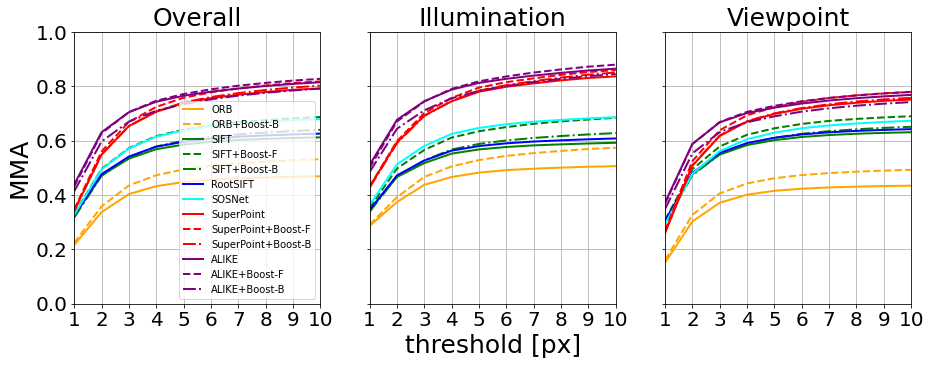

In [18]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _, _, _ = errors[method]
    plt.plot(plt_rng, [(i_err[thr] + v_err[thr]) / ((n_i + n_v) * 5) for thr in plt_rng], color=color, ls=ls, linewidth=2, label=name)
plt.title('Overall')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('MMA')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

plt.subplot(1, 3, 2)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _, _, _ = errors[method]
    plt.plot(plt_rng, [i_err[thr] / (n_i * 5) for thr in plt_rng], color=color, ls=ls, linewidth=2, label=name)
plt.title('Illumination')
plt.xlabel('threshold [px]')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(1, 3, 3)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _, _, _ = errors[method]
    plt.plot(plt_rng, [v_err[thr] / (n_v * 5) for thr in plt_rng], color=color, ls=ls, linewidth=2, label=name)
plt.title('Viewpoint')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('hseq.pdf', bbox_inches='tight', dpi=300)

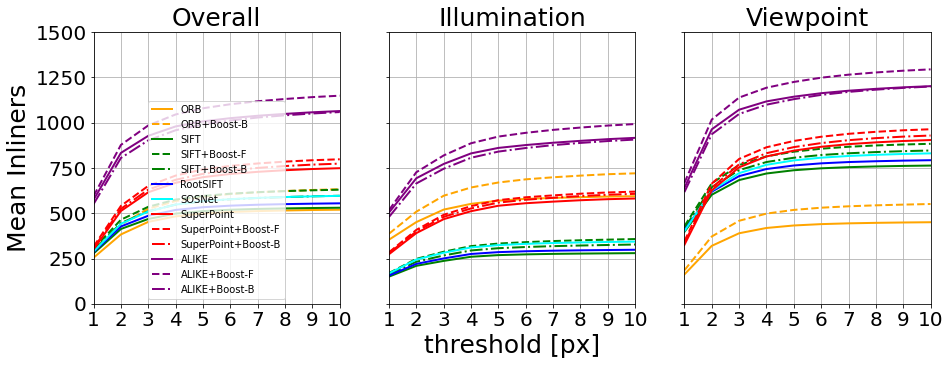

In [19]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    _, _, i_matches, v_matches, _ = errors[method]
    plt.plot(plt_rng, [(i_matches[thr] + v_matches[thr]) / ((n_i + n_v) * 5) for thr in plt_rng], color=color, ls=ls, linewidth=2, label=name)
plt.title('Overall')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('Mean Inliners')
plt.ylim([0, 1500])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

plt.subplot(1, 3, 2)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    _, _, i_matches, v_matches, _ = errors[method]
    plt.plot(plt_rng, [i_matches[thr] / (n_i * 5) for thr in plt_rng], color=color, ls=ls, linewidth=2, label=name)
plt.title('Illumination')
plt.xlabel('threshold [px]')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1500])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(1, 3, 3)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    _, _, i_matches, v_matches, _ = errors[method]
    plt.plot(plt_rng, [v_matches[thr] / (n_v * 5) for thr in plt_rng], color=color, ls=ls, linewidth=2, label=name)
plt.title('Viewpoint')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1500])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)